In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, and_, or_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
M = Base.classes.measurement
S = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB, get the table names
session = Session(engine)
inspector = inspect(engine)
tbls = inspector.get_table_names()
tbls

['measurement', 'station']

In [10]:
#checkout the columns
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
#find max date for calcs below
max(session.query(M.date).all())


('2017-08-23')

# Exploratory Climate Analysis

(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.,
        2250.]), <a list of 10 Text xticklabel objects>)

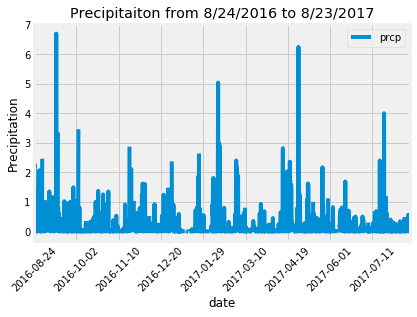

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
prev_year = dt.date(2017,8,23)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(M.date, M.prcp).filter(M.date>prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data)
prcp_df = prcp_df.set_index('date')

# Sort the dataframe by date
prcp_df = prcp_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
ax=prcp_df.plot()
ax.set_title('Precipitaiton from 8/24/2016 to 8/23/2017')
ax.set_ylabel('Precipitation')
plt.xticks(rotation=45)

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
stn_cnt = session.query(S.id).count()
print(f'There are {stn_cnt} stations.')

There are 9 stations.


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
mst_active = session.query(M.station, func.count(M.station).label('cnt_stations')).group_by(M.station).\
              order_by(func.count(M.station).desc()).all()[0][0]
print(f'Most active station: {mst_active}')
# List the stations and the counts in descending order.
all_stns = session.query(M.station, func.count(M.station).label('cnt_stations')).group_by(M.station).\
              order_by(func.count(M.station).desc()).all()
all_stns

Most active station: USC00519281


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
#I think I can do this w/ the * thing, might try that later.
temp = session.query(func.min(M.tobs), func.max(M.tobs), func.avg(M.tobs)).filter(M.station == mst_active).all()
temp

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022256D11470>]],
      dtype=object)

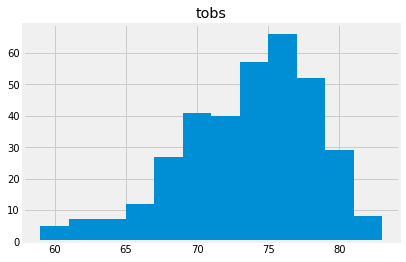

In [17]:
# Choose the station with the highest number of temperature observations.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_df = pd.DataFrame(session.query(M.tobs).filter(and_(M.station == mst_active, M.date>prev_year)).all())
tobs_df.hist(bins=12)

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(M.tobs), func.avg(M.tobs), func.max(M.tobs)).\
        filter(M.date >= start_date).filter(M.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_str='2016-02-28'
trip_end='2016-03-05'
trip_temp_df = pd.DataFrame(calc_temps(trip_str, trip_end), columns=['min','avg','max'])
trip_temp_df

,min,avg,max
0,62.0,69.886364,80.0


Text(0, 0.5, 'Temp (F)')

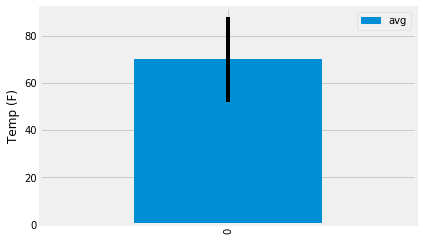

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temp_df.plot.bar(y='avg', yerr=trip_temp_df['max']-trip_temp_df['min'])
plt.ylabel('Temp (F)')

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(M.station, S.name, S.latitude, S.longitude, S.elevation, M.prcp).\
filter(and_(M.station==S.station, M.date >= trip_str, M.date <= trip_end )).\
group_by(M.station).order_by(M.prcp.desc()).all()


[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.0),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.0),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(M.tobs), func.avg(M.tobs), func.max(M.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", M.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip


# push each tuple of calculations into a list called `normals`
trip_dates_raw = session.query(M.date).filter(and_(M.date>=trip_str, M.date<=trip_end)).group_by(M.date).all()
trip_dates=[d[0] for d in trip_dates_raw]


# Set the start and end date of the trip
#this is done above

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings
trip_dates_mmdd = [d[5:] for d in trip_dates]
# Loop through the list of %m-%d strings and calculate the normals for each date

normals = [daily_normals(d)[0] for d in trip_dates_mmdd]
normals


[(65.0, 70.65517241379311, 80.0),
 (67.0, 71.73333333333333, 79.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ['min','avg','max'])
normals_df['date']=trip_dates
normals_df = normals_df.set_index('date')
normals_df

,min,avg,max
date,,,
2016-02-28,65.0,70.655172,80.0
2016-02-29,67.0,71.733333,79.0
2016-03-01,64.0,70.032787,76.0
2016-03-02,61.0,70.366667,78.0
2016-03-03,60.0,70.068966,78.0
2016-03-04,57.0,69.272727,77.0
2016-03-05,60.0,67.890909,76.0


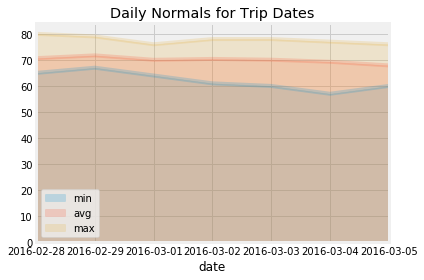

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', alpha=.35, stacked=False, x_compat=True, title="Daily Normals for Trip Dates")
plt.tight_layout()

plt.show()